In [48]:
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import netCDF4 as nc
import numpy as np
import random
from scipy.integrate import ode
from scipy.interpolate import LinearNDInterpolator

%matplotlib inline

* Staggered grids : Done
* Multiple points : Done
* tmask
* e1t etc
* the surface

In [147]:
def interpolator(t_mask, w_coords, v_coords, u_coords, w, v, u, point) :
    dims = len(point)
    rhs = np.zeros((3))
    if t_mask[int(point[1]), int(point[2]), int(point[3]+0.5)] != 0:
        for vel, coords, data in zip([0, 1, 2], [w_coords, v_coords, u_coords], [w, v, u]):
            indices = []
            sub_coords = []
            for j in range(dims) :
                idx = np.digitize([point[j]], coords[j])[0]   # finds the index of region
                if (idx == len(coords[j])):
                    print (j, 'out of bounds', point[j], vel, coords[j])
                if (idx == 0):
                    print (j, 'hit surface', point[j], vel, coords[j])
                indices += [[idx - 1, idx]]
                sub_coords += [coords[j][indices[-1]]]
            indices = np.array([j for j in product(*indices)])
            sub_coords = np.array([j for j in product(*sub_coords)])
            sub_data = data[list(np.swapaxes(indices, 0, 1))]
            li = LinearNDInterpolator(sub_coords, sub_data)
            rhs[vel] = li([point])[0]
    return rhs
# from Jaime on Stackoverflow https://stackoverflow.com/users/110026/jaime

In [119]:
def derivatives(t, poss, t_mask, w_coords, v_coords, u_coords, w, v, u):
    rhs = np.zeros_like(poss)
    for ip in range(int(poss.shape[0]/3)):
        point = np.array([t, poss[0+ip*3], poss[1+ip*3], poss[2+ip*3]])
        rhs[0+ip*3:3+ip*3] = interpolator(t_mask, w_coords, v_coords, u_coords, w, v, u, point)/(
            np.array([1., 500., 440]))
    return np.array(rhs) # array or scalar, not a tuple

# test starter
tlen = 3
nsize = 6
# velocities
u = 1 - 2* np.random.rand(tlen, nsize, nsize, nsize)
v = 1 - 2*np.random.rand(tlen, nsize, nsize, nsize)
w = 1 - 2*np.random.rand(tlen, nsize, nsize, nsize)
# t-coordinates
xcorrs = np.linspace(0, nsize-1, nsize)
ycorrs = np.linspace(0, nsize-1, nsize)
zcorrs = np.linspace(0, nsize-1, nsize)
tcorrs = np.linspace(0, tlen-1, tlen)
longaxis = max(len(xcorrs), len(ycorrs), len(zcorrs), len(tcorrs))
print (longaxis)
t_coords = np.zeros((4, longaxis))
t_coords[0, 0:len(tcorrs)] = tcorrs
t_coords[0, len(tcorrs):] = max(tcorrs)
t_coords[1, 0:len(zcorrs)] = zcorrs
t_coords[1, len(zcorrs):] = max(zcorrs)
t_coords[2, 0:len(ycorrs)] = ycorrs
t_coords[2, len(ycorrs):] = max(ycorrs)
t_coords[3, 0:len(xcorrs)] = xcorrs
t_coords[3, len(xcorrs):] = max(xcorrs)
# other grids
u_coords = np.copy(t_coords)
u_coords[3] = t_coords[3] + 0.5
v_coords = np.copy(t_coords)
v_coords[2] = t_coords[2] + 0.5
w_coords = np.copy(t_coords)
w_coords[1] = t_coords[3] + 0.5
# tmask
t_mask = np.ones((zcorrs.shape[0], ycorrs.shape[0], xcorrs.shape[0]))
print (t_mask.shape)
t_mask[0] = 0
t_mask[-1] = 0
t_mask[:, 0] = 0
t_mask[:, -1] = 0
t_mask[..., 0] = 0
t_mask[..., -1] = 0
print (tcorrs, t_coords[0], u_coords[1], v_coords[2], w_coords[3])

In [208]:
yi = np.zeros((2, 3))

for i in range(npoints):
    yi[i, 0] = random.uniform(0., t_coords[1, -1])
    for j in range(1, 3, 1):
        yi[i, j] = random.uniform(t_coords[j+1, 0], t_coords[j+1, -1])

print (yi)

[[   2.09779632  255.13152487  301.04620357]
 [   2.14403199  269.64935333  305.48853622]]


In [209]:
print (w.shape, w_coords.shape)
print (v.shape, v_coords.shape)
print (u.shape, u_coords.shape)
print (t_mask.shape, t_coords.shape)
print (yi)
testpoint = np.zeros((4))
print (testpoint.shape)
testpoint[1:] = yi[0]
testpoint[0] = t0
print (testpoint)
velocity = interpolator(t_mask, w_coords, v_coords, u_coords, w, v, u, testpoint)
print (velocity)
if np.all(velocity == [0, 0, 0]):
    t_mask[int(testpoint[1]), int(testpoint[2]), int(testpoint[3]+0.5)] = 0
    print (int(testpoint[1]), int(testpoint[2]), int(testpoint[3]+0.5), 'zerod')
testpoint[1:] = yi[1]
print (testpoint)
velocity = interpolator(t_mask, w_coords, v_coords, u_coords, w, v, u, testpoint)
print (velocity)
if np.all(velocity == [0, 0, 0]):
    t_mask[int(testpoint[1]), int(testpoint[2]), int(testpoint[3]+0.5)] = 0
    print (int(testpoint[1]), int(testpoint[2]), int(testpoint[3]+0.5), 'zerod')

(3, 6, 21, 21) (4, 21)
(3, 6, 21, 21) (4, 21)
(3, 6, 21, 21) (4, 21)
(40, 898, 398) (4, 21)
[[   2.09779632  255.13152487  301.04620357]
 [   2.14403199  269.64935333  305.48853622]]
(4,)
[  1.49709780e+09   2.09779632e+00   2.55131525e+02   3.01046204e+02]
[ -7.52405035e-05  -1.17523409e-03  -5.56893306e-03]
[  1.49709780e+09   2.14403199e+00   2.69649353e+02   3.05488536e+02]
[  2.21622758e-04  -2.32075628e-03  -4.01388744e-01]


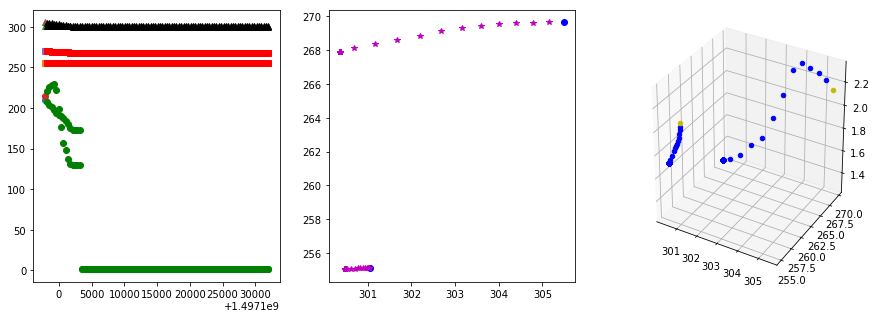

In [220]:
# fig, ax = plt.subplots(1, 3, figsize=(10, 5))
fig = plt.figure(figsize=(15, 5))
ax[0] = fig.add_subplot(1, 3, 1)
ax[1] = fig.add_subplot(1, 3, 2)
ax[2] = fig.add_subplot(1, 3, 3, projection='3d')
myintegrator = ode(derivatives).set_integrator('dopri5', atol=0.01)
t0 = tcorrs[0]
npoints = 2
scale = 100.
y0 = np.copy(yi)

yp = np.ndarray.flatten(y0)

for ip in range(npoints):
    ax[0].plot(t0, y0[ip, 0]*scale, 'o')
    ax[0].plot(t0, y0[ip, 1], 's')
    ax[0].plot(t0, y0[ip, 2], '^')
    ax[1].plot(y0[ip, 2], y0[ip, 1], 'bo')
    ax[2].scatter(y0[ip, 2], y0[ip, 1], y0[ip, 0], c='y')
    

myintegrator.set_initial_value(yp, t0).set_f_params(t_mask, w_coords, v_coords, u_coords, w, v, u)
dt = deltat/10.
t1 = t0 + 1.5*deltat

while myintegrator.successful() and myintegrator.t < t1:
    myintegrator.integrate(myintegrator.t + dt)
    y0 = np.reshape(myintegrator.y, (npoints, 3))
    for ip in range(npoints):
        ax[0].plot(myintegrator.t, y0[ip, 0]*scale, 'go')
        ax[0].plot(myintegrator.t, y0[ip, 1], 'rs')
        ax[0].plot(myintegrator.t, y0[ip, 2], 'k^')
        ax[1].plot(y0[ip, 2], y0[ip, 1], 'm*')
        ax[2].scatter(y0[ip, 2], y0[ip, 1], y0[ip, 0], c='b')


for count in range(8):
        
    # update arrays
    tcorrs, u_coords, v_coords, w_coords, u, v, w, nextindex = (
        update_arrays(tcorrs, u_coords, v_coords, w_coords, u, v, w, deltat, nextindex))
    t1 += deltat

    while myintegrator.successful() and myintegrator.t < t1:
        myintegrator.integrate(myintegrator.t + dt)
        y0 = np.reshape(myintegrator.y, (npoints, 3))
        for ip in range(npoints):
            ax[0].plot(myintegrator.t, y0[ip, 0], 'go')
            ax[0].plot(myintegrator.t, y0[ip, 1], 'rs')
            ax[0].plot(myintegrator.t, y0[ip, 2], 'k^')
            ax[1].plot(y0[ip, 2], y0[ip, 1], 'm*')
            ax[2].scatter(y0[ip, 2], y0[ip, 1], y0[ip, 0], c='b')

In [216]:
def update_arrays(tcorrs, u_coords, v_coords, w_coords, u, v, w, deltat, nextindex):
    tcorrs  = tcorrs + deltat
    u_coords[0, 0:len(tcorrs)] = tcorrs
    u_coords[0, len(tcorrs):] = max(tcorrs)
    v_coords[0] = u_coords[0]
    w_coords[0] = u_coords[0]
    u[0:2] = u[1:3]
    u[2, 1:] = udataset['uVelocity'][nextindex]
    u[2, 0] = 2 * u[2, 2] - u[2, 1]
    v[0:2] = v[1:3]
    v[2, 1:] = vdataset['vVelocity'][nextindex]
    v[2, 0] = 2 * v[2, 2] - v[2, 1]
    w[0:2] = w[1:3]
    w[2] = wdataset['wVelocity'][nextindex]
    nextindex += 1
    return tcorrs, u_coords, v_coords, w_coords, u, v, w, nextindex

In [212]:
print (u.shape)

(3, 6, 21, 21)


In [219]:
udataset = nc.Dataset('/Users/sallen/Downloads/ubcSSn3DuVelocity1hV16-10_9411_b69f_35e1.nc')
# print (udataset)
tcorrs = udataset['time'][:3]
deltat = tcorrs[1] - tcorrs[0]
xcorrs = udataset['gridX'][:]
ycorrs = udataset['gridY'][:]
depthsize = udataset['depth'][:].shape[0]
zcorrs = np.linspace(-0.5, depthsize-0.5, depthsize+1)

longaxis = max(len(xcorrs), len(ycorrs), len(zcorrs), len(tcorrs))
print (longaxis)
t_coords = np.zeros((4, longaxis))
t_coords[0, 0:len(tcorrs)] = tcorrs
t_coords[0, len(tcorrs):] = max(tcorrs)
t_coords[1, 0:len(zcorrs)] = zcorrs
t_coords[1, len(zcorrs):] = max(zcorrs)
t_coords[2, 0:len(ycorrs)] = ycorrs
t_coords[2, len(ycorrs):] = max(ycorrs)
t_coords[3, 0:len(xcorrs)] = xcorrs
t_coords[3, len(xcorrs):] = max(xcorrs)
print (t_coords.shape)
# other grids
u_coords = np.copy(t_coords)
u_coords[3] = t_coords[3] + 0.5
v_coords = np.copy(t_coords)
v_coords[2] = t_coords[2] + 0.5
w_coords = np.copy(t_coords)
w_coords[1] = t_coords[1] + 0.5

u = np.zeros((3, len(zcorrs), len(ycorrs), len(xcorrs)))
print (u.shape)
u[:, 1:] = udataset['uVelocity'][0:3]
u[:, 0] = 2 * u[:, 2] - u[:, 1]
print (u.shape)

v = np.zeros_like(u)
vdataset = nc.Dataset('/Users/sallen/Downloads/ubcSSn3DvVelocity1hV16-10_a2b6_f6ad_26bd.nc')
v[:, 1:] = vdataset['vVelocity'][0:3]
v[:, 0] = 2 * v[:, 2] - v[:, 1]
print (v.shape)

wdataset = nc.Dataset('/Users/sallen/Downloads/ubcSSn3DwVelocity1hV16-10_9d37_aa6f_428c.nc')
w = np.zeros_like(u)
w = wdataset['wVelocity'][0:3]
nextindex = 3

t_mask = np.ones((40, 898, 398))
print (t_mask.shape)
t_mask[5:] = 0
t_mask[:, 0:int(t_coords[2, 0]+1)] = 0
t_mask[:, int(t_coords[2, -1]):] = 0
t_mask[..., 0:int(t_coords[3, 0]+1)] = 0
t_mask[..., int(t_coords[3, -1]):] = 0

print (t_coords[1, 2], t_coords[2, 0], t_coords[3, 2])
print (u[0, 2, 5, 2], v[0, 2, 5, 2], w[0, 2, 5, 2])
print (t_mask[2, 250, 311])
print (t_mask[4, 258, 312])
print (zcorrs)

21
(4, 21)
(3, 6, 21, 21)
(3, 6, 21, 21)
(3, 6, 21, 21)
(40, 898, 398)
1.5 250.0 302.0
-0.00781892426312 0.0108764423057 5.67423e-05
0.0
1.0
[-0.5  0.5  1.5  2.5  3.5  4.5]


In [ ]:
2.99800437  250.21963892  311.72698054
4.16521453  258.96741365  312.76911944